# Facebook Prophet Colab

In [1]:
# Basic imports for loading data and plotting
import pandas as pd
import matplotlib.pyplot as plt

# For saving and importing serialized model
import json
import urllib.request

# Prophet imports
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import add_changepoints_to_plot
# from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_forecast_component
from prophet.plot import plot_seasonality
from prophet.serialize import model_to_json, model_from_json

In [2]:
from prophet.diagnostics import performance_metrics
import numpy as np

def plot_cross_validation_metric(
    df_cv, metric, rolling_window=0.1, ax=None, figsize=(10, 6), color='b',
    point_color='gray'):
    """Plot a performance metric vs. forecast horizon from cross validation.

    Cross validation produces a collection of out-of-sample model predictions
    that can be compared to actual values, at a range of different horizons
    (distance from the cutoff). This computes a specified performance metric
    for each prediction, and aggregated over a rolling window with horizon.

    This uses prophet.diagnostics.performance_metrics to compute the metrics.
    Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.

    rolling_window is the proportion of data included in the rolling window of
    aggregation. The default value of 0.1 means 10% of data are included in the
    aggregation for computing the metric.

    As a concrete example, if metric='mse', then this plot will show the
    squared error for each cross validation prediction, along with the MSE
    averaged over rolling windows of 10% of the data.

    Parameters
    ----------
    df_cv: The output from prophet.diagnostics.cross_validation.
    metric: Metric name, one of ['mse', 'rmse', 'mae', 'mape', 'coverage'].
    rolling_window: Proportion of data to use for rolling average of metric.
        In [0, 1]. Defaults to 0.1.
    ax: Optional matplotlib axis on which to plot. If not given, a new figure
        will be created.
    figsize: Optional tuple width, height in inches.
    color: Optional color for plot and error points, useful when plotting
        multiple model performances on one axis for comparison.

    Returns
    -------
    a matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
    ax.plot(x_plt_h, df_h[metric], '-', c=color)
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

In [3]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

## Divvy hourly example

### Prepare and inspect the data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/raffg/prophet_presentation/main/data/divvy_hourly_with_temperature.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temperature', 'weather']

In [5]:
# Remove final 2 weeks of training data
train = df[df['ds'] <= pd.to_datetime('2017-12-18 00:00:00')].copy()

In [6]:
# Basic model

model1 = Prophet()
model1.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
# Advanced model

df['rain_or_snow'] = df['weather'] == 'rain or snow'
train['rain_or_snow'] = train['weather'] == 'rain or snow'

model2 = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                weekly_seasonality=6,
                daily_seasonality=False,
                changepoint_prior_scale=.001)

model2.add_country_holidays(country_name='US')

model2.add_regressor('temperature')
model2.add_regressor('rain_or_snow')

df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

train['weekend'] = train['ds'].apply(is_weekend)
train['weekday'] = ~train['ds'].apply(is_weekend)

model2.add_seasonality(name='daily_weekend',
                      period=1,
                      fourier_order=3,
                      condition_name='weekend')
model2.add_seasonality(name='daily_weekday',
                      period=1,
                      fourier_order=3,
                      condition_name='weekday')

model2.fit(train)

In [8]:
# Alternative model 1

model3 = Prophet(seasonality_mode='additive')
model3.add_country_holidays(country_name='US')
model3.add_regressor('temperature')
model3.add_regressor('rain_or_snow')
model3.add_seasonality(name='daily_weekend',
                      period=1,
                      fourier_order=3,
                      condition_name='weekend')
model3.add_seasonality(name='daily_weekday',
                      period=1,
                      fourier_order=3,
                      condition_name='weekday')
model3.fit(train)

In [9]:
# Alternative model 2

model4= Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=2,
                weekly_seasonality=2,
                changepoint_prior_scale=.5)
model4.add_country_holidays(country_name='US')
model4.add_regressor('temperature')
model4.add_regressor('rain_or_snow')
model4.add_seasonality(name='daily_weekend',
                      period=1,
                      fourier_order=10,
                      condition_name='weekend')
model4.add_seasonality(name='daily_weekday',
                      period=1,
                      fourier_order=10,
                      condition_name='weekday')
model4.fit(train)

### Evaluate model performance

In [10]:
df_cv1 = cross_validation(model1,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffe27e70ca0>


In [11]:
df_cv2 = cross_validation(model2,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffe27796790>


In [12]:
df_cv3 = cross_validation(model3,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffe01ec6220>


In [13]:
df_cv4 = cross_validation(model4,
                         horizon='14 days',
                         period='7 days',
                         initial='1095 days',
                         parallel='processes')

INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-12-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffe12c31d60>


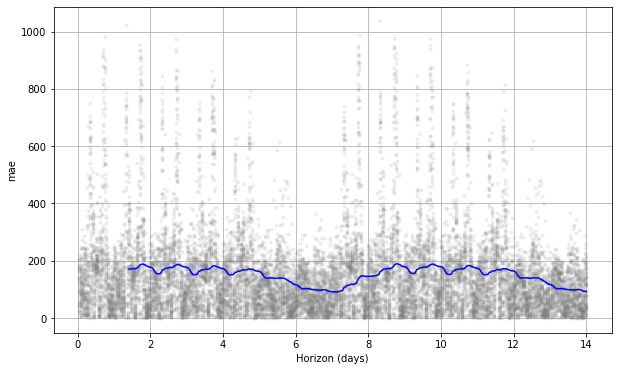

In [14]:
fig = plot_cross_validation_metric(df_cv2, metric='mae')
plt.show()

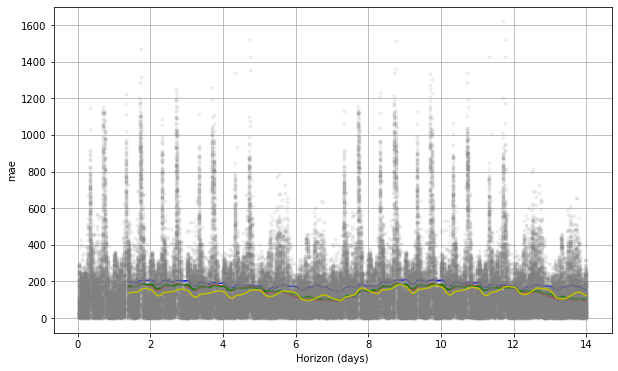

In [15]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='#4285F4')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='#DB4437')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='#F4B400')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='#0F9D58')
plt.show()

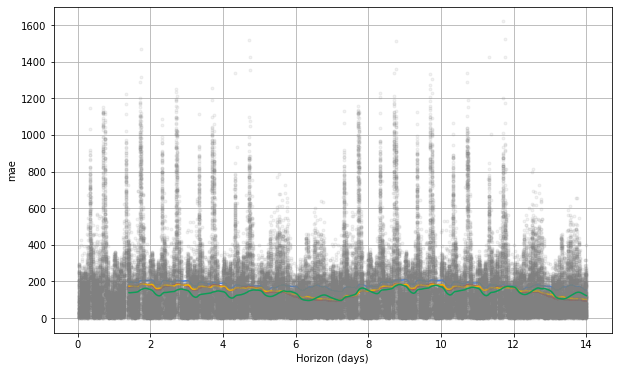

In [16]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='#4285F4')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='#DB4437')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='#F4B400')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='#0F9D58')
plt.show()

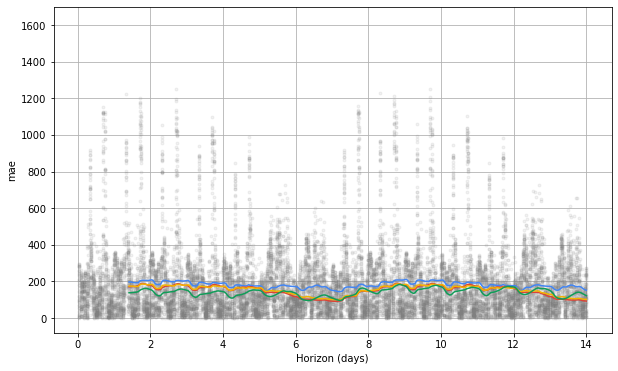

In [17]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='#4285F4')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='#DB4437', point_color='None')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='#F4B400', point_color='None')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='#0F9D58', point_color='None')
plt.show()

In [18]:
from prophet.plot import plot_cross_validation_metric as plot_cv

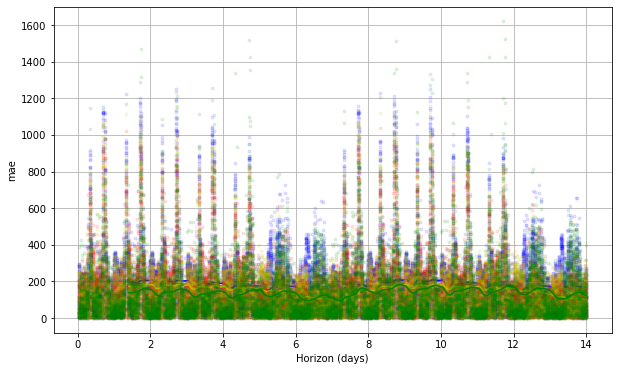

In [19]:
fig = plot_cv(df_cv1, metric='mae', color='b')
plot_cv(df_cv2, metric='mae', ax=fig.gca(), color='r')
plot_cv(df_cv3, metric='mae', ax=fig.gca(), color='y')
plot_cv(df_cv4, metric='mae', ax=fig.gca(), color='g')
plt.show()

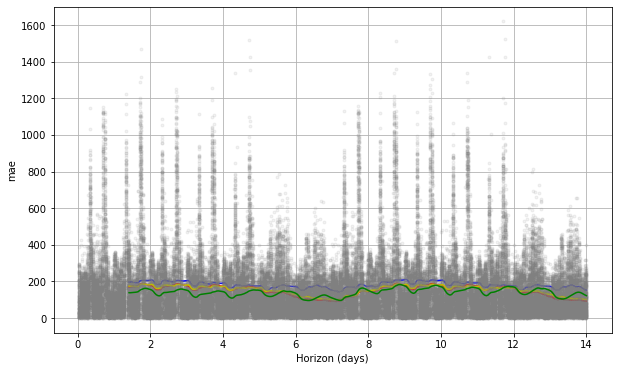

In [20]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='b')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='r')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='y')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='g')
plt.show()

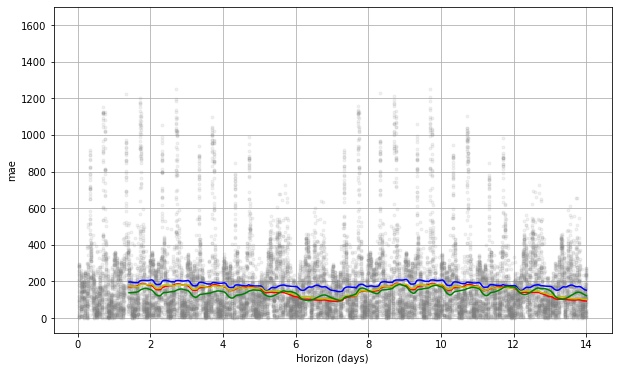

In [21]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='b')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='r', point_color='None')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='y', point_color='None')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='g', point_color='None')
plt.show()

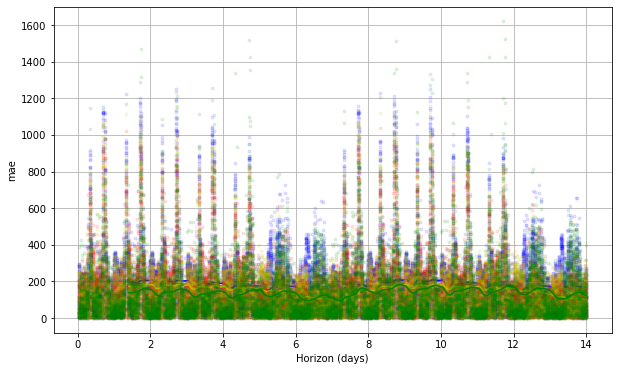

In [22]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='b', point_color='b')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='r', point_color='r')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='y', point_color='y')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='g', point_color='g')
plt.show()

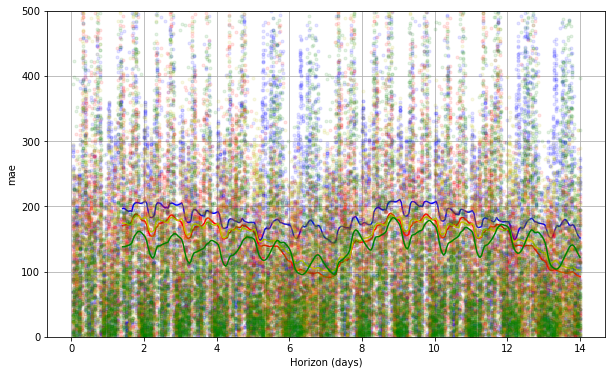

In [26]:
fig = plot_cv(df_cv1, metric='mae', color='b')
plot_cv(df_cv2, metric='mae', ax=fig.gca(), color='r')
plot_cv(df_cv3, metric='mae', ax=fig.gca(), color='y')
plot_cv(df_cv4, metric='mae', ax=fig.gca(), color='g')
plt.ylim(0, 500)
plt.show()

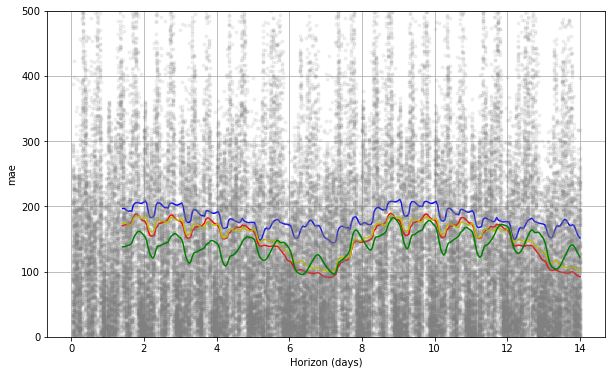

In [27]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='b')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='r')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='y')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='g')
plt.ylim(0, 500)
plt.show()

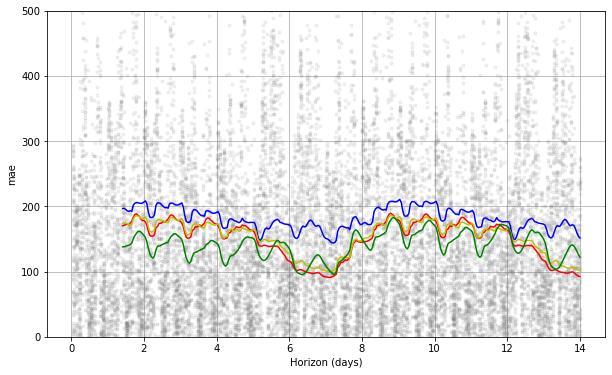

In [25]:
fig = plot_cross_validation_metric(df_cv1, metric='mae', color='b')
plot_cross_validation_metric(df_cv2, metric='mae', ax=fig.gca(), color='r', point_color='None')
plot_cross_validation_metric(df_cv3, metric='mae', ax=fig.gca(), color='y', point_color='None')
plot_cross_validation_metric(df_cv4, metric='mae', ax=fig.gca(), color='g', point_color='None')
plt.ylim(0, 500)
plt.show()